# Classification

In this notebook, I'll provide workflows for doing classification using a non-Iris, multi-class dataset

In [235]:
# Load libraries

# General DS Libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm

# Pre-processing and Scoring
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, classification_report, precision_recall_curve, average_precision_score, confusion_matrix

# Bit to make statmodels Logit work
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# Lime for interpreting things
import lime
import lime.lime_tabular

# Set up to use Latex
#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

## Part 1: Some Simple Binary Classification

Making a binary classification model, I can use lots of different strategies:

* Logistic Regression
* Naive Bayes
* K-Nearest Neighbors
* Simple Decision Tree
* Random Forest
* Gradient Boosting

First, I'm going to download the titanic dataset, which has binary "survived/not" data and clean it up:

### Data Cleaning and Feature Engineering

In [2]:
# Load titanic dataset and print out info
titanic = sns.load_dataset('titanic')
print(titanic.info())
print(titanic.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
survived       891 non-null int64
pclass         891 non-null int64
sex            891 non-null object
age            714 non-null float64
sibsp          891 non-null int64
parch          891 non-null int64
fare           891 non-null float64
embarked       889 non-null object
class          891 non-null category
who            891 non-null object
adult_male     891 non-null bool
deck           203 non-null category
embark_town    889 non-null object
alive          891 non-null object
alone          891 non-null bool
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB
None
   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.92

Right off the bat, there's some work to be done here:

* `Deck`, `Age`, `Embarked` and `Embark_Town` all have missing values. Treatment will likely be different for them:
    * `Deck` only has 203 non-null values. I'll check what the value counts are below, but I'm probably going to drop this OR make a variable where "is_missing" is one of the options
    * `Age` is missing a good chunk of values; this seems like a good place to do some interpolation and maybe set the missing age to a mean/median value of the particular group, based on the other variables
    * `Embarked` and `Embark_town` look like they're actually the same variable and probably don't have any important information. So while I could just drop the 2 missing rows, I think I'll just drop them

* The `survived` and `alive` columns seem redundant; I'm going to have to drop the latter. Also, the `who` and `sex` seem redundant. I'm going to have to look at those two later. The `adult_male` column is probably also redundant here; I'm getting rid of it
Here's a look at the values in the deck column:

In [3]:
titanic.deck.value_counts(dropna=False)

NaN    688
C       59
B       47
D       33
E       32
A       15
F       13
G        4
Name: deck, dtype: int64

The problem here is that most values are missing; I don't think this is going to be super-useful, so I'll drop that column. I'm also going to drop the columns with embark, alive, adult_male, and class information, all of which are redundant. Then I'm going to print out the age stats

In [21]:
# Remove 3 columns
titanic_small = titanic.drop(['deck','embarked','embark_town','alive','adult_male', 'class'], axis='columns')

# Print out the age stats
titanic_small['age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64

The mean/median are pretty close to one another. But before I go filling things, I want to take a look at the "who" column; I think that'll be important in case it tells me who the children are:

In [22]:
titanic_small.who.value_counts()

man      537
woman    271
child     83
Name: who, dtype: int64

So the age filling is actually more complex; what I'm going to do is calculate the group-specific medians and use those to fill:

In [23]:
group_medians = titanic_small.groupby('who')['age'].median()
group_medians

who
child     5.0
man      30.0
woman    30.0
Name: age, dtype: float64

Actually, can fill them in 1 command with transform:

In [24]:
# Fill the age
titanic_small['age'] = titanic_small.groupby('who')['age'].transform(lambda x: x.fillna(x.median()))
titanic_small.groupby('who')['age'].median()

who
child     5.0
man      30.0
woman    30.0
Name: age, dtype: float64

Unsurprisingly, the medians didn't move at all; this is a good sanity check. Now I have all filled values, but there's still one problem: some predictors are still categorical or object types; I'm going to convert these to numerics by one-hot encoding. Just to look again, here's the info on the data:

In [25]:
titanic_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
survived    891 non-null int64
pclass      891 non-null int64
sex         891 non-null object
age         891 non-null float64
sibsp       891 non-null int64
parch       891 non-null int64
fare        891 non-null float64
who         891 non-null object
alone       891 non-null bool
dtypes: bool(1), float64(2), int64(4), object(2)
memory usage: 56.6+ KB


So really, I just have sex and who here. Given that "who" is now neatly encapsulated in age + sex, this is probably pretty redundant. But I'll keep both for now and make them into dummy variables.

In [26]:
# Create the dummy variables
titanic_small = pd.get_dummies(titanic_small,
                               columns = ['sex','who'],
                               prefix = ['sex','who'])
titanic_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
survived      891 non-null int64
pclass        891 non-null int64
age           891 non-null float64
sibsp         891 non-null int64
parch         891 non-null int64
fare          891 non-null float64
alone         891 non-null bool
sex_female    891 non-null uint8
sex_male      891 non-null uint8
who_child     891 non-null uint8
who_man       891 non-null uint8
who_woman     891 non-null uint8
dtypes: bool(1), float64(2), int64(4), uint8(5)
memory usage: 47.1 KB


Just to wrap this all up, here's the correlations between everything:

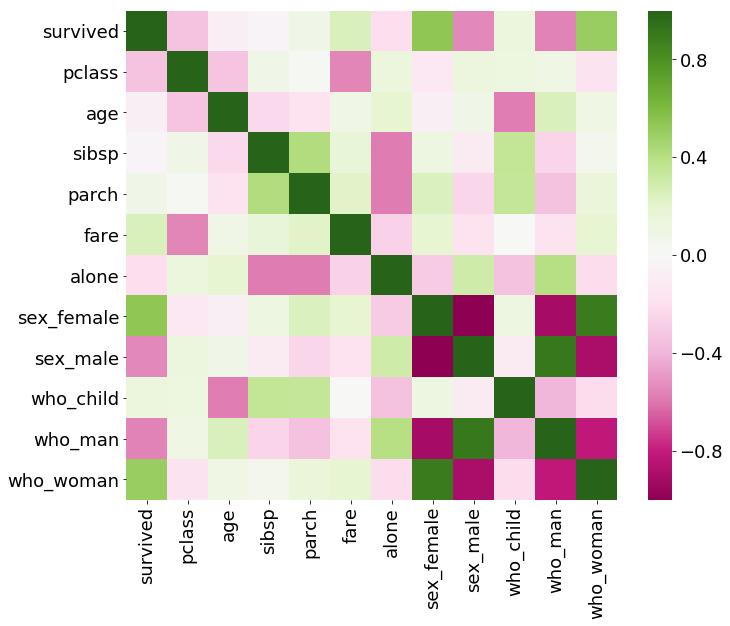

In [27]:
# Set up the matplotlib figure
matplotlib.rcParams.update({'font.size': 18})
f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(titanic_small.corr(),
            cmap = 'PiYG')

A quick note on sibsp and parch:

* sibsp is # simblings/spouses aboard
* parch is # Parents/children aboard

So people who had these are pretty anti-correlated with "alone", as you'd expect

Looking at the correlations as a whole, women (and females in general were most likely to survive and men (and males) were least likely. Children were somewhere in the middle, probably because although we'd probably make the greatest effort to save them, they would be least able to fend for themselves. 

For final modeling, I'm going to drop the "who" and just keep the "sex" columns. If I drop the "sex", I can't tell male from female children, but if I drop the "who", the ages will let me tell who's a child and who's an adult. 

In [28]:
# Drop the "who" columns
titanic_final = titanic_small.drop(['who_child', 'who_man', 'who_woman'], axis = 'columns')

And now, a quick visualization of the cleaned data:

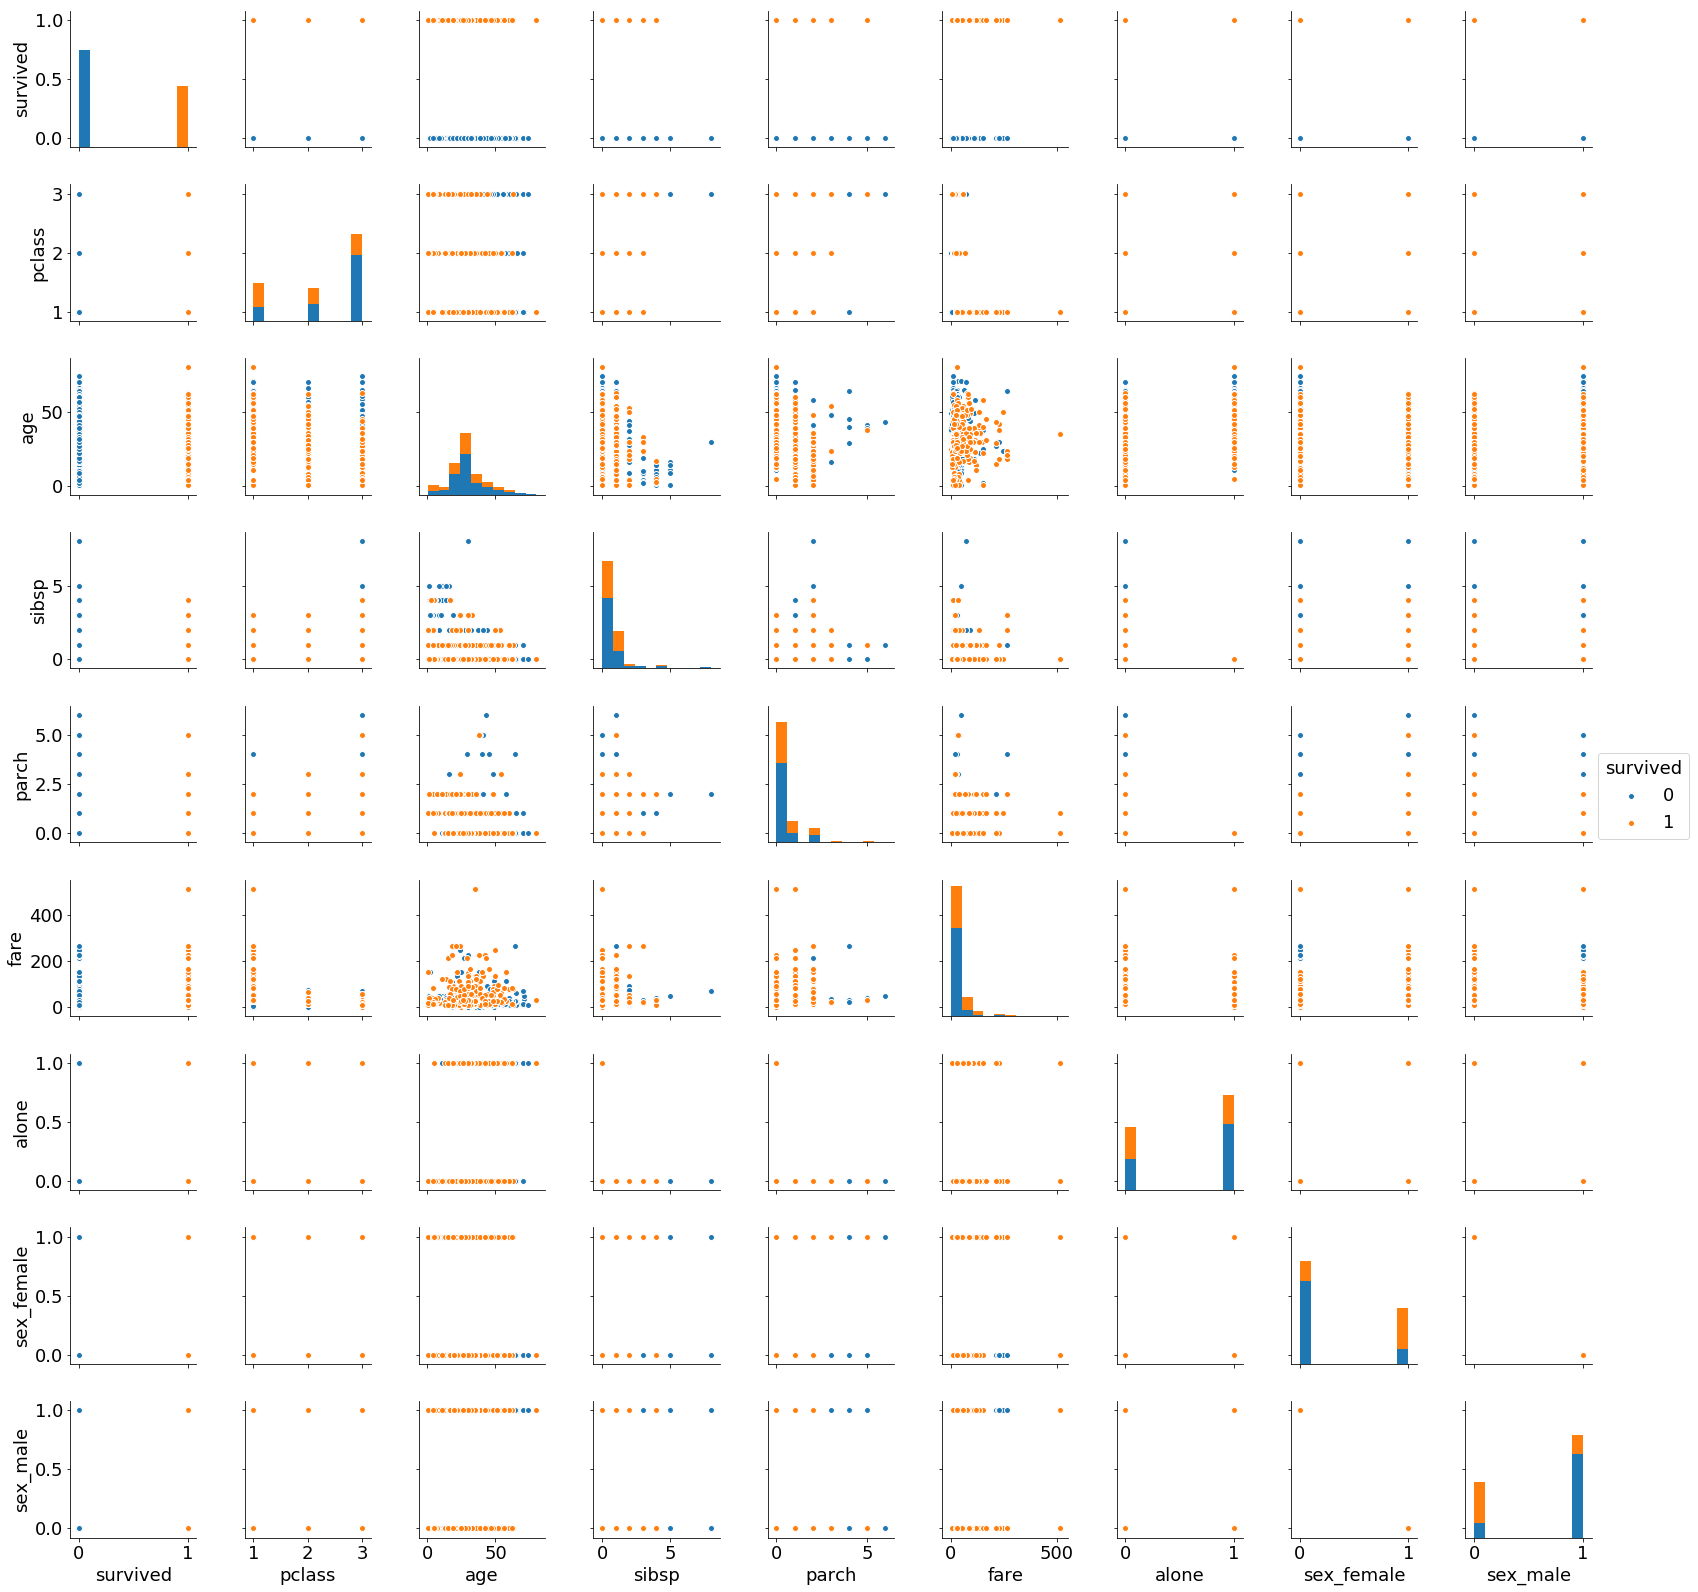

In [166]:
# Make a pair plot
sns.pairplot(titanic_final, hue='survived')
plt.show()

So to summarizze here:

* About 1/3 of people survived
* People in lower class (class 3) were less likely to survive; first class looks like 50/50
* Looks like a midpoint in age is the ideal place to be and being old really hurts your chances
* Having no siblings or spouse may or may not be a plus, same as having parents or children
* Paying a high fare looks beneficial
* Not being alone looks beneficial
* Being female REALLY helps your chances

Now then, on to machine learning

### Machine Learning

Time to learn things! I'll split into training/testing sets:

In [29]:
# Split X and Y
X = titanic_final.drop(['survived'], axis = 1, inplace=False)
Y = titanic_final['survived']

# Split to train/test (80/20 split)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 12)

Now I'll make a predictAndROC function to make a prediction and make a ROC curve as well

In [33]:
def predictAndRoc(model, model_name, X_test, Y_test, plot_flag = True):
    
    '''Given a fit binary classification model and test data, predict and plot in comparison to actual'''
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    # Compute actual predictions too
    y_pred = model.predict(X_test)

    # Calculate the AUC
    auc_score = roc_auc_score(Y_test, y_pred_prob)

    # Plot ROC curve if plot flag
    if plot_flag:        
        # Generate ROC curve values: fpr, tpr, thresholds
        fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC for {}'.format(model_name))
        plt.text(x = 0.75, y = 0.05, s = "AUC = {:0.3f}".format(auc_score))
        plt.show()
    
    return y_pred

Now it's time to actually create the classifiers. This is the fun part!

In [31]:
# Create all classifiers
lr = LogisticRegression()
nb = GaussianNB()
kn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

Now I'll run that on a handful of different models, starting with a logistic regression and going through the rest. I'll just run all using list comprehensions:

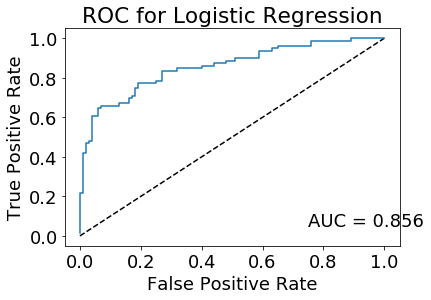

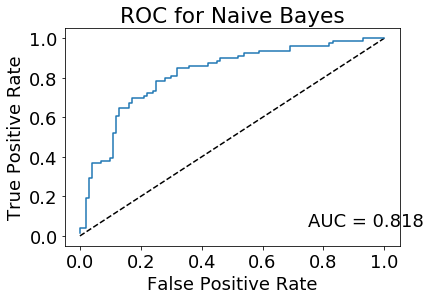

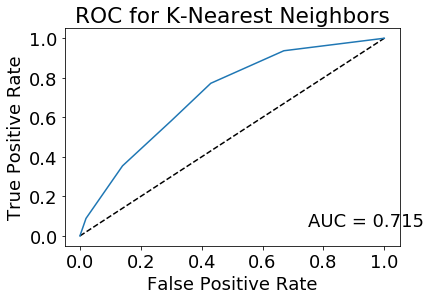

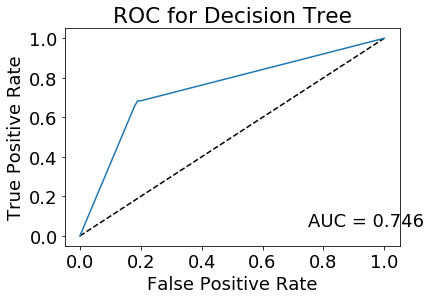

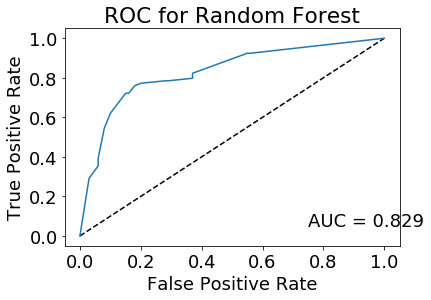

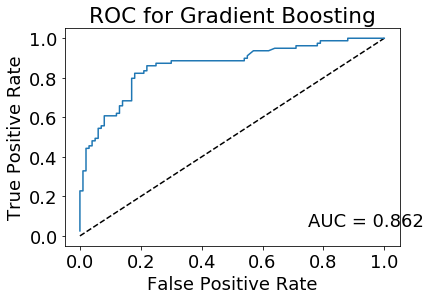

0.7210884353741497
0.7189542483660132
0.5935483870967743
0.7105263157894737
0.7500000000000001
0.7346938775510204


In [37]:

# Put them in a list and zip them with a list of names
all_classifiers = [lr, nb, kn, dt, rf, gb]
all_names = ['Logistic Regression',
             'Naive Bayes',
             'K-Nearest Neighbors',
             'Decision Tree',
             'Random Forest', 
             'Gradient Boosting']
zipped_classifiers = zip(all_classifiers, all_names)

# Fit all using list comprehension
_ = [model.fit(X_train, Y_train) for model in all_classifiers]

# Do the ROC prediction for each
y_pred_all = [predictAndRoc(model, name, X_test, Y_test, True) for model, name in zipped_classifiers]

# Print all their F1 scores
_ = [print(f1_score(Y_test, y_pred)) for y_pred in y_pred_all]


As shown, there's a pretty sizable range in performance. Just in terms of sheer performance via AUC, it's:

1. Gradient Boosting - very powerful and complex, 2nd highest F1 score too
2. Logistic Regression - simple and interpretable, 3rd highest F1 score
3. Random Forest - very powerful and complex, highest F1 score
4. Naive Bayes - simple and pretty interpretable, 4th highest F1 score
5. Decision Tree - also simple and interpretable, 5th highest F1 score
6. K-Nearest Neighbors - simple algorithm, worst in F1 by far

To get a better look at what's being mis-classified, I'll also create the classification reports for each case:

In [40]:
all_reports = [classification_report(Y_test, model.predict(X_test)) for model in all_classifiers]

_ = [print(name, report) for name, report in zip(all_names, all_reports)]

Logistic Regression              precision    recall  f1-score   support

          0       0.77      0.85      0.81       100
          1       0.78      0.67      0.72        79

avg / total       0.77      0.77      0.77       179

Naive Bayes              precision    recall  f1-score   support

          0       0.77      0.81      0.79       100
          1       0.74      0.70      0.72        79

avg / total       0.76      0.76      0.76       179

K-Nearest Neighbors              precision    recall  f1-score   support

          0       0.68      0.70      0.69       100
          1       0.61      0.58      0.59        79

avg / total       0.65      0.65      0.65       179

Decision Tree              precision    recall  f1-score   support

          0       0.76      0.81      0.79       100
          1       0.74      0.68      0.71        79

avg / total       0.75      0.75      0.75       179

Random Forest              precision    recall  f1-score   support

      

Looks like in general, it's a lot easier to predict who didn't survive, with each model getting about a 0.8 F1 score (except the bad KNN model) in that group and about a 0.7 (again, not the KNN) in the surviving group. The random forest is actually most notable for its ability to predict survivors, particularly in its recall. If I'm being honest, the top 5 models aren't all that different by these metrics. 

If I were to choose a particular model here, I'd probably go with logistic regression. It does 2nd best by AUC, has the 2nd best precision and comparably good recall on the survivors, and it's really interpretable. Just for comparison's sake, I'm going to carry forward a bit with both logistic regression AND with random forest. 

### Visualizing Model Performance

Now that I just have my 2 models, I want to drill down a bit on their performance and look at how each performs. The logistic regression model is fairly simple in that I can, like linear regression, go back and train a model using a different package: 

In [52]:
Y_train.reshape(-1,1).shape

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


(712, 1)

In [69]:
X2 = sm.add_constant(X_train)
lr_full = sm.Logit(Y_train, X2.astype('float'))
result = lr_full.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.430542
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      704
Method:                           MLE   Df Model:                            7
Date:                Mon, 06 Aug 2018   Pseudo R-squ.:                  0.3463
Time:                        10:46:55   Log-Likelihood:                -306.55
converged:                       True   LL-Null:                       -468.94
                                        LLR p-value:                 3.048e-66
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4339   4.74e+07   5.13e-08      1.000    -9.3e+07     9.3e+07
pclass        -1.0493      0.158     -6.627      0.000      -1.360      -0.739
age           -0.0325      0.009     -3.617      0.000      -0.050      -0.015
sibsp         -0.4724      0.163     -2.905      0.004      -0.791      -0.154
parch         -0.1521      0.149     -1.022      0.307      -0.444       0.140
fare           0.0021      0.002      0.856      0.392      -0.003       0.007
alone         -0.5823      0.320     -1.820      0.069      -1.209       0.045
sex_female     2.5606   4.74e+07    5.4e-08      1.000    -9.3e+07     9.3e+07
sex_male      -0.1268   4.74e+07  -2.67e-09      1.000    -9.3e+07     9.3e+07
==============================================================================
"""

As shown here, there are 3 variables with pretty notable coefficients (pclass, age, sisp). Based on direction here, it looks like younger passengers in lower class numbers (e.g. 1st class) without siblings or spouses may have had the best chance at survival. 

I'm a little suprised that the male/female didn't have a better P value. Weird. 

Now I'm going to use the original model and make sure the coefficients plot out similarly:

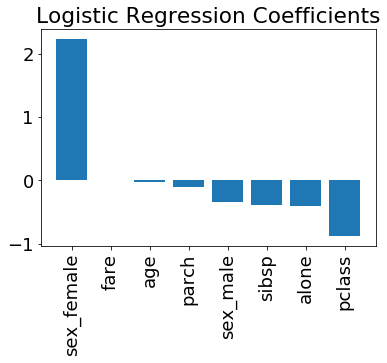

In [102]:
# Extract the coefficients
coefficients = lr.coef_.flatten()
idx = np.flip(np.argsort(coefficients), 0)
labels =np.array(titanic_final.drop(['survived'], axis = 1).columns)
plt.figure()
tick_range = list(range(len(coefficients)))
plt.bar(tick_range,coefficients[idx])
plt.xticks(tick_range, labels[idx], rotation='vertical')
plt.title('Logistic Regression Coefficients')
plt.show()

What I find interesting is that like the detailed report I just looked at, the sex_female has the highest coefficient by far, but it didn't have significance there. I wonder what would happen if I dropped the sex_male:

In [103]:
X2 = sm.add_constant(X_train.drop(['sex_male'], axis = 'columns'))
lr_full = sm.Logit(Y_train, X2.astype('float'))
result = lr_full.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.430542
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      704
Method:                           MLE   Df Model:                            7
Date:                Mon, 06 Aug 2018   Pseudo R-squ.:                  0.3463
Time:                        12:07:34   Log-Likelihood:                -306.55
converged:                       True   LL-Null:                       -468.94
                                        LLR p-value:                 3.048e-66
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3071      0.606      3.804      0.000       1.118       3.496
pclass        -1.0493      0.158     -6.627      0.000      -1.360      -0.739
age           -0.0325      0.009     -3.617      0.000      -0.050      -0.015
sibsp         -0.4724      0.163     -2.905      0.004      -0.791      -0.154
parch         -0.1521      0.149     -1.022      0.307      -0.444       0.140
fare           0.0021      0.002      0.856      0.392      -0.003       0.007
alone         -0.5823      0.320     -1.820      0.069      -1.209       0.045
sex_female     2.6874      0.226     11.880      0.000       2.244       3.131
==============================================================================
"""

That makes much more sense; the female factor is clearly the biggest driver and it's HIGHLY significant; it's just hard to tell when you have the male factor there too. 

Now that I've looked at the logistic regression, I would pose that the following groups have the highest chance of survival:

* Females! This is by far the biggest factor!
* 1st class (or just lower number class) passengers
* Young people
* People without siblings or spouses aboard

I'm done with logistic regression; I'm moving on to looking at random forest. First, the feature importances:

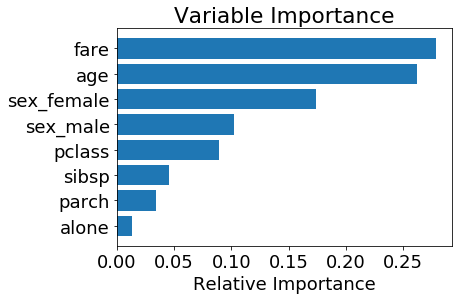

In [104]:
# Sort by feature importances
sorted_idx = np.argsort(rf.feature_importances_)

# Set bar positions and plot them as such
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, rf.feature_importances_[sorted_idx], align='center')

# Use the index and the labels (from LM code) to label
importance_labels = [labels[i] for i in sorted_idx]
plt.yticks(pos, importance_labels)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

This is quite a big difference, as the fare is now the biggest importance and is followed by age. The sex is next. I wonder if I should try without the sex_male...

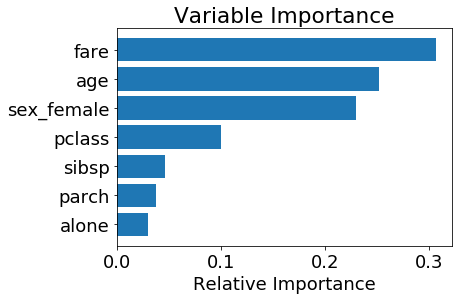

In [105]:
rf_no_male = RandomForestClassifier()
rf_no_male.fit(X_train.drop(['sex_male'], axis = 'columns'), Y_train)

# Sort by feature importances
sorted_idx = np.argsort(rf_no_male.feature_importances_)

# Set bar positions and plot them as such
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, rf_no_male.feature_importances_[sorted_idx], align='center')

# Use the index and the labels (from LM code) to label
importance_labels = [labels[i] for i in sorted_idx]
plt.yticks(pos, importance_labels)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Still looks about the same, but female sex is closer to age. I find this fascinating because fare wasn't really important at all for the logistic regression; it had a low coefficient AND insignificant P-value. To bring this home, I'm going to apply LIME:

In [124]:
# Create the explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.drop(['sex_male'], axis = 'columns').values, # Point at the features
                                                   mode = 'classification',  # Tell it we're doing regression
                                                   feature_names=list(X_train.drop(['sex_male'], axis = 'columns').columns), # Give names to the features
                                                   class_names=['perished', 'survived'], # Name the classes in order
                                                   verbose = True) # Print out more text

# Explain a particular point that we predict with the moel
exp = explainer.explain_instance(X_test.drop(['sex_male'], axis = 'columns').iloc[0], rf_no_male.predict_proba, num_features = 6)
exp.show_in_notebook(show_table = True)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Intercept 0.6136290722091842
Prediction_local [0.16237713]
Right: 0.1


Here we see a case where we predict death.....interestingly, the fare doesn't show up. But...

* Passenger is not female, which really hurts
* Class is 1st, which apparently helps, but not enough
* They have no parents or children, which hurts
* They're 65, which is not beneficial
* They have no siblings or spouse, which actually helps
* They're alone, which hurts survival chances

Overwhelmingly, the big factor here is the fact that the person is male, as that outweighs everything else. Let's try another instance, this time for a person who is predicted to survive

In [123]:
# Explain a particular point that we predict with the moel
exp = explainer.explain_instance(X_test.drop(['sex_male'], axis = 'columns').iloc[1], rf_no_male.predict_proba, num_features = 6)
exp.show_in_notebook(show_table = True)

Intercept 0.5754460962618184
Prediction_local [0.31422597]
Right: 0.6


Here we see someone who is also male, who is also in first class and is traveling alone, but we now see no age information, seeing fare information instead. Somehow, this somewhat similar person is predicted to survive. 

This is kind of fun, but I think it's run its course. The last thing I'd like to do is plot precision recall curves for these 2 models. I'll make a little function:

In [157]:
def plotPrecRec(model, model_name, X_test, Y_test):
    '''Plot the precision recall curve for the model'''
    precision, recall, _ = precision_recall_curve(Y_test, model.predict_proba(X_test)[:,1])

    average_precision = average_precision_score(Y_test, model.predict_proba(X_test)[:,1])
    
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('{} Average Precision: {:0.2f}'.format(model_name,average_precision))

Now I'll use it on both models, first random forest:

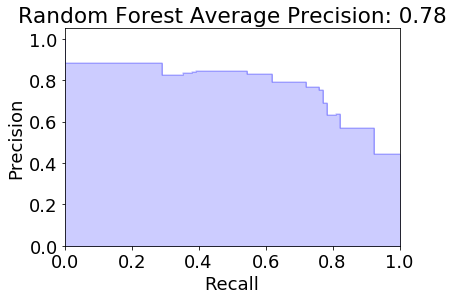

In [158]:
plotPrecRec(rf, 'Random Forest', X_test, Y_test)

Now logistic regression:

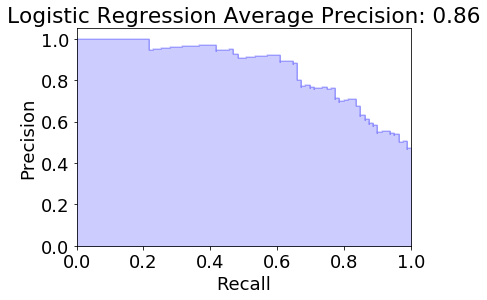

In [159]:
plotPrecRec(lr, 'Logistic Regression', X_test, Y_test)

Interesting; the precision of LR tends to be higher on average and definitely at the higher end. Yet more support for logistic regression!

That's about all I want to do for binary classification; I can now move on to the multi-class version.

## Part 2: Multiclass Classification

This is trickier because I now have to deal with all 3 classes. I'll need to bring in another dataset; hopefully the iris dataset will work just fine, but we'll see. More difficult is visualization; I'll do this using a heat map of the confusion matrix instead. 

First let's bring in the data!

In [161]:
# Bring in iris data and check it out
iris = sns.load_dataset('iris')
print(iris.info())
iris.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
species         150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB
None


sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

As is my habit, let's visualize this via plotting:

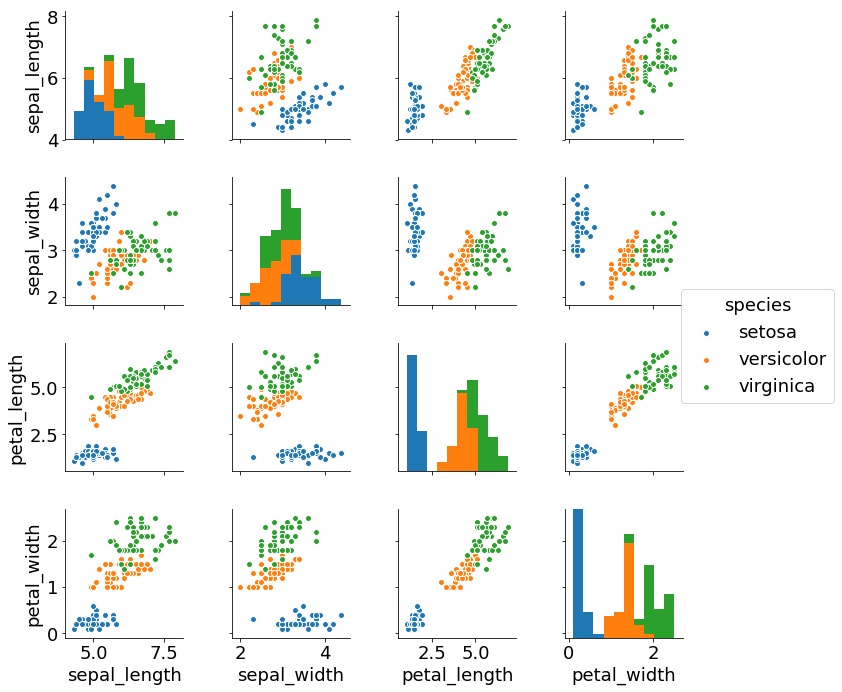

In [163]:
# Make a pair plot
sns.pairplot(iris, hue='species')
plt.show()

Takeaways here:

* Setosa looks really easy to separate from the others, particularly based on petal dimensions
* Petals in general look like the most helpful feature, with the order going setosa -> versicolor -> virginica
* Sepals also separate the classes, but the setosa are shorter and wider while virginica is longer and thinner; versicolor falls in the middle

This looks pretty easy to separate, so hopefully the classifiers will do a good job.

I'm only going to use 2 different classifiers this time: random forest and logistic regression. Notably, any of the others can be plugged in here, but I don't see much point.

### 1: Logistic Regression

The issue here is that I have multiple classes; I'll get around that by using a OneVsRest approach:

In [169]:
# Create the classifier object
lr = OneVsRestClassifier(LogisticRegression())

I also need to encode the labels as digits; I'll use the label encoder for this:

In [182]:
le = LabelEncoder()
iris['species'] = le.fit_transform(iris['species'])

Now I'll try fitting each classifier. To do that, I do need to actually split up the data; I'll use lower letters this time:

In [183]:
# Split X and Y
x = iris.drop(['species'], axis = 1, inplace=False)
y = iris['species']

# Split to train/test (80/20 split)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 12)

# Train both models
lr = lr.fit(x_train, y_train)
rf = rf.fit(x_train, y_train)

Okay, so now I'll try the two classifiers by creating a new function:

In [228]:
def predictMulticlass(model, model_name, x_test, y_test):
    '''Predict with the fit model'''
    
    # Predictions!
    y_pred = model.predict(x_test)
    
    # Print out the model name
    print('{} model performance:'.format(model_name))
    
    # Print out the classification report
    print(classification_report(y_test, y_pred))
    
    # Print out the overall score
    print('Overall Accuracy: {:0.2f}'.format(model.score(x_test, y_test)))
    
    
    # Get the overall score (accuracy?)
    return model.score(x_test, y_test)

In [231]:
_ = predictMulticlass(lr, "Logistic Regression", x_test, y_test)

Logistic Regression model performance:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        12
          1       1.00      0.89      0.94         9
          2       0.90      1.00      0.95         9

avg / total       0.97      0.97      0.97        30

Overall Accuracy: 0.97


In [232]:
_ = predictMulticlass(rf, "Random Forest", x_test, y_test)

Random Forest model performance:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        12
          1       1.00      0.89      0.94         9
          2       0.90      1.00      0.95         9

avg / total       0.97      0.97      0.97        30

Overall Accuracy: 0.97


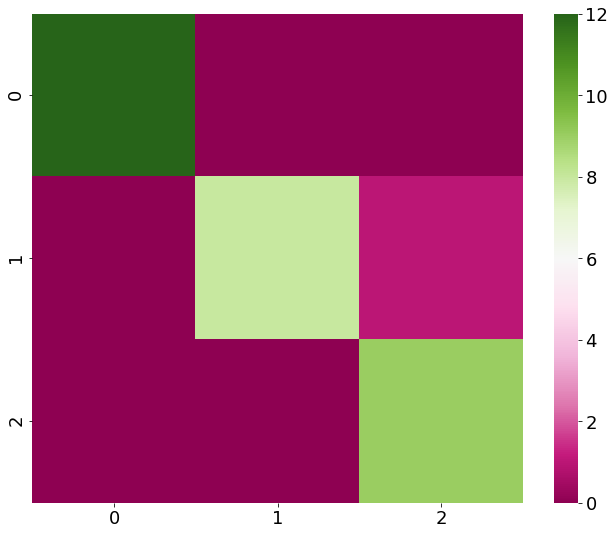

In [236]:
blah = confusion_matrix(y_test, rf.predict(x_test))

# Set up the matplotlib figure
matplotlib.rcParams.update({'font.size': 18})
f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(blah,
            cmap = 'PiYG')

In [249]:
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    #pc.update_scalarmappable()
   # ax = pc.get_axes()
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))

def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        #print(v)
        plotMat.append(v)

    #print('plotMat: {0}'.format(plotMat))
    #print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, 
            xticklabels, yticklabels, 
            figure_width, figure_height, 
            correct_orientation, cmap=cmap)

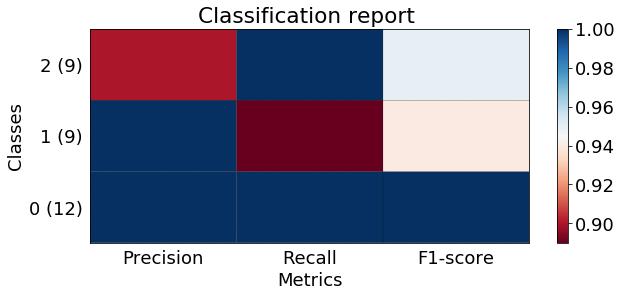

In [251]:
plot_classification_report(classification_report(y_test, rf.predict(x_test)))

Well, I think that's sufficient plotting of the confusion matrix and classification report. I am moving on at this point. 

## Part 3: Cross validating models

I'm just going to do this for the multiclass case; it should extend to binary easily enough. I'll use f1 score as the validation metric, as it compromises between precision and recall. 

In [ ]:
# Function for one model
def doCV(classifier, X, y): 
        
    # Create models
    cv_scores = cross_val_score(classifier, X, y, cv = 5,
                                 scoring = 'f1')
      
    # Return MAE
    return np.mean(cv_scores)